In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pylab as plt
import itertools
from itertools import compress, product

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

In [2]:
model = nn.Sequential(
    nn.Linear(5, 5),
    nn.ReLU(),
    
    nn.Linear(5, 10),
    nn.ReLU(),
    
    nn.Linear(10, 15),
    nn.ReLU(),
    
    nn.Linear(15, 20),
    nn.ReLU(),
    
    nn.Linear(20, 15),
    nn.ReLU(),
    
    nn.Linear(15, 10),
    nn.ReLU(),
    
    nn.Linear(10, 5),
    nn.ReLU(),
    
    nn.Linear(5, 3),
    nn.Softmax(),
)

In [3]:
actions_0_MountainCar= np.load("MountainCar/MountainCar_actions_2.npy")
actions_0_MountainCar = torch.tensor(actions_0_MountainCar, dtype=torch.float)
print("actions_0_MountainCar.shape",actions_0_MountainCar.shape)

actions_0_MountainCar.shape torch.Size([5000, 200, 1])


In [4]:
def pre_processing (array, n=3):
    ep, t, _= array.shape
    output = torch.zeros ((ep*(t-n), n+1))
    index=0
    indices = []
    for i in range (ep):
        for j in range (t-n):
            output[index] = array[i, j:j+n+1].view(-1)
            index+=1
    for i in range (output.shape[0]):
        if (output[i] < torch.zeros(n+1)).any():
            indices.append(i)
    cleaned_data = torch.tensor(np.delete(np.array(output), indices, axis=0))
    return cleaned_data
new_data  = pre_processing(actions_0_MountainCar, 5)
new_data.shape

torch.Size([503264, 6])

In [5]:
training_set = new_data[:400000]
testing_set = new_data[400000:]
print("training_set", training_set.shape)
print("testing_set", testing_set.shape)

training_set torch.Size([400000, 6])
testing_set torch.Size([103264, 6])


# traning

In [6]:
losses = []
n_itrations=100
batch_size=256
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
for itr in range (n_itrations):
    if itr%50 ==0:
        torch.save(model, "MountainCar_model_n=5")  
    total_loss = 0
    total_acc = []
    for b in range (0, training_set.shape[0], batch_size):
        y = torch.tensor(training_set[b:b+batch_size, -1], dtype=torch.long)
        y_pred = model(training_set[b:b+batch_size, :5])
        score, predicted = torch.max(y_pred, 1)
        acc = (y == predicted).sum().float() / len(y)
        total_acc.append(acc)
#         print("y_pred", y_pred)
        loss = loss_function(y_pred, y)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(total_loss)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (itr, total_loss, np.mean(np.array(total_acc)) ))
#     print("[EPOCH]: %i, [LOSS]: %.6f ,[acc]: %.3f" % (itr, total_loss, np.mean(np.array(total_acc))))

/home/montaser/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/home/montaser/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


[EPOCH]: 0, [LOSS]: -1354.146815, [ACCURACY]: 0.878
[EPOCH]: 1, [LOSS]: -1420.445346, [ACCURACY]: 0.909
[EPOCH]: 2, [LOSS]: -1427.717474, [ACCURACY]: 0.916
[EPOCH]: 3, [LOSS]: -1449.374569, [ACCURACY]: 0.933
[EPOCH]: 4, [LOSS]: -1455.770364, [ACCURACY]: 0.933
[EPOCH]: 5, [LOSS]: -1457.364932, [ACCURACY]: 0.933
[EPOCH]: 6, [LOSS]: -1457.942505, [ACCURACY]: 0.933
[EPOCH]: 7, [LOSS]: -1458.216857, [ACCURACY]: 0.933
[EPOCH]: 8, [LOSS]: -1458.337942, [ACCURACY]: 0.933
[EPOCH]: 9, [LOSS]: -1458.396367, [ACCURACY]: 0.933
[EPOCH]: 10, [LOSS]: -1458.425016, [ACCURACY]: 0.933
[EPOCH]: 11, [LOSS]: -1458.439172, [ACCURACY]: 0.933
[EPOCH]: 12, [LOSS]: -1458.446184, [ACCURACY]: 0.933
[EPOCH]: 13, [LOSS]: -1458.449684, [ACCURACY]: 0.933
[EPOCH]: 14, [LOSS]: -1458.451407, [ACCURACY]: 0.933
[EPOCH]: 15, [LOSS]: -1458.452317, [ACCURACY]: 0.933
[EPOCH]: 16, [LOSS]: -1458.452585, [ACCURACY]: 0.933
[EPOCH]: 17, [LOSS]: -1458.452965, [ACCURACY]: 0.933
[EPOCH]: 18, [LOSS]: -1458.453089, [ACCURACY]: 0.933
[EP

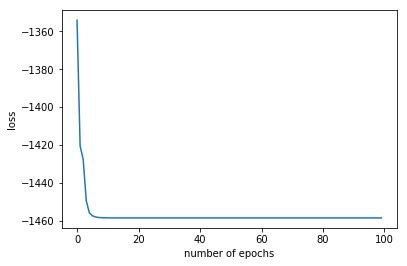

In [7]:
torch.save(model, "MountainCar_model_n=5") 
plt.plot(losses)
plt.xlabel("number of epochs")
plt.ylabel("loss")
plt.show()

# test

In [8]:
y = torch.tensor(testing_set[:, -1], dtype=torch.long)
y_pred = model(testing_set[:, :5])
score, predicted = torch.max(y_pred, 1)
acc = (y == predicted).sum().float() / len(y)
print("accuracy = %.4f "%acc.item())

accuracy = 0.9375 


/home/montaser/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


# PCA

In [9]:
m = torch.load("MountainCar_model_n=5")
m[:8]

Sequential(
  (0): Linear(in_features=5, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=15, bias=True)
  (5): ReLU()
  (6): Linear(in_features=15, out_features=20, bias=True)
  (7): ReLU()
)

In [10]:
def prepare_inputs (n): 
    a=[0, 1,2]
    return torch.tensor([list(i) for i in itertools.product(a, repeat=n)], dtype=torch.float)

In [11]:
zom = prepare_inputs(5)
zom.shape

torch.Size([243, 5])

In [13]:
zom[121]

tensor([1., 1., 1., 1., 1.])

In [14]:
vectors = m[:8](zom).detach().numpy()
vectors.shape

(243, 20)

In [15]:
pca = PCA(n_components=2, svd_solver='full' ).fit_transform(vectors)
pca.shape

(243, 2)

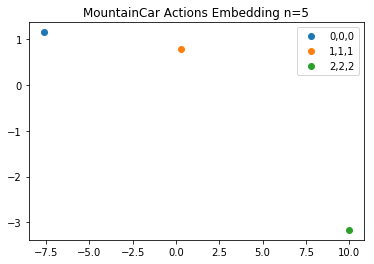

In [16]:
# for i in range (pca.shape[0]):
#     plt.plot(list(pca[i])[0], list(pca[i])[1] ,"o", label="{}".format(list(np.array(zom[i], dtype=np.int))))
plt.plot(list(pca[0])[0], list(pca[0])[1] ,"o", label="0,0,0")
# plt.plot(list(pca[2])[0], list(pca[1])[1] ,"o", label="0,0,2")
# plt.plot(list(pca[6])[0], list(pca[3])[1] ,"o", label="0,2,0")
# plt.plot(list(pca[19])[0], list(pca[3])[1] ,"o", label="2,0,0")
plt.plot(list(pca[121])[0], list(pca[121])[1] ,"o", label="1,1,1")
plt.plot(list(pca[-1])[0], list(pca[-1])[1] ,"o", label="2,2,2")
plt.title("MountainCar Actions Embedding n=5")
plt.legend()
plt.savefig("fig/MountainCar_n=5", dpi=600)

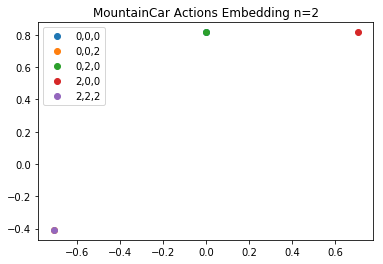

In [19]:
plt.plot(list(pca[0])[0], list(pca[0])[1] ,"o", label="0,0,0")
plt.plot(list(pca[2])[0], list(pca[1])[1] ,"o", label="0,0,2")
plt.plot(list(pca[6])[0], list(pca[3])[1] ,"o", label="0,2,0")
plt.plot(list(pca[19])[0], list(pca[3])[1] ,"o", label="2,0,0")
plt.plot(list(pca[-1])[0], list(pca[-1])[1] ,"o", label="2,2,2")

plt.title("MountainCar Actions Embedding n=2")
plt.legend()